## Inicjalizacja środowiska programistycznego

In [63]:
#Color printing
from termcolor import colored

#General data operations library
import math
import string
from datetime import datetime
import numpy as np

#The tensorflow library
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"
import tensorflow  as tf

#Plotting libraries
import matplotlib as mpl
import matplotlib.pyplot as plt

#Increase plots font size
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (10, 7),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
plt.rcParams.update(params)

#append path with python modules
import importlib
import sys
sys.path.append("/Users/jakubkusmierski/Desktop/Uczenie_Maszynowe_2/modules")

#Private functions
import plotting_functions as plf
importlib.reload(plf);

<br/><br/>
<br/><br/>

<h1 align="center">
 Uczenie maszynowe II
</h1>

<br/><br/>
<br/><br/>
<br/><br/>
<br/><br/>

<h1 align="right">
Artur Kalinowski <br>
Uniwersytet Warszawski <br>
Wydział Fizyki <br>    
</h1>

Dane w postaci pary macierzy `x,y` są mało wydajne w sytuacji gdy jest ich dużo, lub są rozmieszczone w wielu plikach.
TF dostarcza dedykowaną klasę do obsługi strumienia wejścia:
```Python
tf.data.Dataset(variant_tensor)
```

Klasa `tf.Dataset` pozwala na zaawansowane operacje na danych. Implementacja tych operacji korzysta równoległego przetwarzania danych w celu zwiększenia przepustowości strumienia wejścia: `liczby przykładów na sekundę`.



Obiekt `tf.Dataset` można tworzyć na wiele sposobów:

* z macierzy:

```Python
dataset = tf.data.Dataset.from_tensor_slices([1, 2, 3])
```

* z funkcji typu generator

```Python
dataset = tf.data.Dataset.from_generator(...)
```

* z pliku typu CSV

```Python
dataset = tf.data.TextLineDataset(...)
```

* z pliku zawierającego dane w dedykowanym formacie `TFRecord`

```Python
dataset = tf.data.TFRecordDataset(["file1.tfrecords", "file2.tfrecords"])
```



Konstrukcja `tf.data.Dataset` z macierzy NumPy

In [2]:
nExamples = 5
nFeatures = 3
epsilon = 0.01
x = tf.random.uniform((nExamples, nFeatures), minval=-1, maxval=1, dtype=tf.float32, name="features")
y = tf.math.reduce_sum(x**2, axis=1)
y = tf.reshape(y, (-1, 1))

print(colored("Features shape:", "blue"), x.shape)
print(colored("Labels shape:", "blue"), y.shape)

dataset = tf.data.Dataset.from_tensor_slices((x, y))
print(dataset)
print(colored("Dataset lenght:", "blue"), len(dataset))

Features shape: (5, 3)
Labels shape: (5, 1)
<_TensorSliceDataset element_spec=(TensorSpec(shape=(3,), dtype=tf.float32, name=None), TensorSpec(shape=(1,), dtype=tf.float32, name=None))>
Dataset lenght: 5


`tf.Dataset` zachowuje się jak kolekcja - można po niej iterować łatwo dostosowując liczbę analizowanych elementów i punkt startowy:

In [3]:
print(colored("Iteration over the full dataset", "blue"))
for item in dataset:
    print(item)

print(colored("Iteration over n elements", "blue"))
n = 3
for item in dataset.take(n):
    print(item)

print(colored("Iteration over n elements starting from m", "blue"))
n = 3
m = 2
for item in dataset.skip(m).take(n):
    print(item)

print(colored("Access single element", "blue"))
item = next(iter(dataset))
print(item)

Iteration over the full dataset
(<tf.Tensor: shape=(3,), dtype=float32, numpy=array([-0.87121487, -0.89152   , -0.92166615], dtype=float32)>, <tf.Tensor: shape=(1,), dtype=float32, numpy=array([2.4032917], dtype=float32)>)
(<tf.Tensor: shape=(3,), dtype=float32, numpy=array([ 0.94926643,  0.05977917, -0.5149193 ], dtype=float32)>, <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.1698222], dtype=float32)>)
(<tf.Tensor: shape=(3,), dtype=float32, numpy=array([-0.7686925 ,  0.30634403, -0.9686363 ], dtype=float32)>, <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.6229911], dtype=float32)>)
(<tf.Tensor: shape=(3,), dtype=float32, numpy=array([0.16150475, 0.37659836, 0.72014475], dtype=float32)>, <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.68651855], dtype=float32)>)
(<tf.Tensor: shape=(3,), dtype=float32, numpy=array([ 0.24000454, -0.37377405, -0.55248904], dtype=float32)>, <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.50255334], dtype=float32)>)
Iteration over

2025-05-14 11:09:24.679031: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-05-14 11:09:24.697633: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-05-14 11:09:24.710079: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


### Konstrukcja `tf.Dataset` z funkcji generującej.

Bardzo wygoną metodą jest użycie funkcji genretujęcaj - [generatora](https://wiki.python.org/moin/Generators).

W tym wypadku oprócz funkcji generującej musimy podać informacje o kształcie i typie danych generowanych przez funkcję:
```Python
dataset = tf.data.Dataset.from_generator(
         generator,                                      # funkcja generująca
         output_signature=(                              # opis kształtu i typu
             (tf.TensorSpec(shape=(3), dtype=tf.float32),# danych generowanych
             tf.TensorSpec(shape=(1), dtype=tf.int32)))  # przez funkcję
    )
```

In [4]:
#Generator function definition
nFeatures = 3

def points3DGenerator():
    while True:
        x = tf.random.uniform(shape=(nFeatures,), minval=-1, maxval=1, dtype=tf.float32, name="features")
        y = tf.math.reduce_sum(x**2, axis=0)
        y = tf.reshape(y, (1))
        yield x,y

#Dataset from generator
dataset = tf.data.Dataset.from_generator(points3DGenerator,
         output_signature=(
             (tf.TensorSpec(shape=(nFeatures,), dtype=tf.float32, name="features"),
             tf.TensorSpec(shape=(1), dtype=tf.float32, name="labels")))
    )

In [5]:
print(colored("Iteration over n elements starting from m", "blue"))
n = 3
m = 2
for item in dataset.skip(m).take(n):
    print(item)

Iteration over n elements starting from m
(<tf.Tensor: shape=(3,), dtype=float32, numpy=array([ 0.24030781, -0.63580894, -0.40979624], dtype=float32)>, <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.62993383], dtype=float32)>)
(<tf.Tensor: shape=(3,), dtype=float32, numpy=array([-0.43253517, -0.7280383 , -0.85860443], dtype=float32)>, <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.4543281], dtype=float32)>)
(<tf.Tensor: shape=(3,), dtype=float32, numpy=array([ 0.17101383, -0.12876534, -0.6859205 ], dtype=float32)>, <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.51631314], dtype=float32)>)


2025-05-14 11:09:30.415575: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Na zbiorze `tf.Dataset` można wykonywać różne operacje przekształcenia:

```Python
dataset = dataset.repeat(n) - # powtarza dane n razy
                              # W sytuacji gdy nie podano argumentu
                              # dane są powtarzane w nieskończoność.
```

**Uwaga:** nie trzeba używać `repeat` by uzyskać wiele epok w czasie treningu. Funkcja `model.fit(...)`
sama zarządza wielokrotnymi przejściami przez zbiór danych

```Python
dataset = dataset.batch(n)   - # grupowanie zbioru w paczki.
                               # W czasie treningu paczki są automatycznie
                               # rozpoznane i nie trzeba (nie wolno) podawać
                               # rozmiaru paczki explicite.
```

```Python
dataset = dataset.skip(m)    - # opuszcza pierwsze m przykładów
                              
```

```Python
dataset = dataset.take(n)    - # ogranicza zbiór do pierwszych n przykładów
                              
```

```Python
dataset = dataset.skip(m).take(n)    - # opuszcza pierwsze m, oraz bierze
                                       # kolejne n przykładów
                              
```

In [6]:
dataset_batched = dataset.batch(2)

#Access a single example (batch in this case)
it = iter(dataset_batched)
print(colored("Features shape:", "blue"), next(it)[0].numpy().shape)
print(colored("Labels shape:", "blue"), next(it)[1].numpy().shape)

print(colored("Iteration over n elements starting from m", "blue"))
m = 5
n = 1
for item in dataset_batched.skip(m).take(n):
    print(colored("\tLabels:\n","blue"),item[0].numpy())
    print(colored("\tFeatures:\n","blue"),item[1].numpy())

Features shape: (2, 3)
Labels shape: (2, 1)
Iteration over n elements starting from m
	Labels:
 [[ 0.87762237 -0.06325412 -0.7072439 ]
 [ 0.9570117  -0.67939353  0.19811225]]
	Features:
 [[1.2744162]
 [1.4166955]]


2025-05-14 11:09:33.354551: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


```Python
dataset = dataset.filter(func)    - # filtruje zbiór na podstawie odpowiedzi
                                    # funkcji func(...) przyjmującej wiersz ze zbioru
                                    # jako argument i zwaracjącej zmienną logiczną
                              
```

```Python
dataset = dataset.shuffle(buffer_size) - # tasuje zbiór używając bufora o rozmiarze
                                         # buffer_size
                              
```

```Python
dataset = dataset.cache() -              # buforuje dane w podtaci binarnej.
                                         # Opcja bardzo użyteczna jeśli operacje wstępnego przetwarzania
                                         # są czaso chłonne.
                              
```

Zbiór danych można poddać też ogólnej transformacji zmieniającej zawartość poszczególnych wierszy:
```Python
dataset_transformed = dataset.map(func) # func to funkcja przyjmująca dany wiersz i zwracająca nowy.
                                        # Nowy wiersz nie musi mieć tego samego kształcu co stary.
```

In [7]:
#use square value of features
def func(features, label):
    return features**2, label

dataset_cached = dataset.take(12).cache()
for item in dataset_cached:
    pass

dataset_transformed = dataset_cached.map(func)

print(colored("Iteration over original dataset", "blue"))
for item in dataset_cached.skip(m).take(n):
    print(colored("\tLabels:","blue"),item[0].numpy())
    print(colored("\tFeatures:","blue"),item[1].numpy())

print(colored("Iteration over transformed dataset", "blue"))
for item in dataset_transformed.skip(m).take(n):
    print(colored("\tLabels:","blue"),item[0].numpy())
    print(colored("\tFeatures:","blue"),item[1].numpy())

Iteration over original dataset
	Labels: [-0.68783903 -0.57229924  0.8952935 ]
	Features: [1.6021994]
Iteration over transformed dataset
	Labels: [0.47312254 0.32752642 0.8015504 ]
	Features: [1.6021994]


2025-05-14 11:09:37.026355: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-05-14 11:09:37.043887: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-05-14 11:09:37.051501: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


**Proszę:**

* skopiować funkcję `discGenerator` z poprzednich zajęć
* stworzyć zbiór `tf.Dataset` obrazów kół korzystając bezpośrednio z generatora. Proszę przyjąć rozdzielczość 256 $\times$ 256
* wypisać na ekran kształ pojedynczego przykładu

In [11]:
def discGenerator(res=256):

    from skimage.draw import disk
    while True:
        center = tf.random.uniform([2], minval=0, maxval = res, dtype=tf.int32, name='center')
        radius = tf.random.uniform([1], minval=5, maxval = res//2, dtype=tf.int32, name='radius')
        shape = (res, res)
        image = np.full(shape, 0)
        yy, xx = disk(center=center.numpy(), radius=radius.numpy()[0], shape=shape)
        image[xx,yy] = 1
        features = tf.concat(values=(center, radius), axis=0 )
        label = tf.constant(image, dtype=tf.int32, name='image')
        label = tf.reshape(label, (res, res, 1))
        yield  features, label
        
nFeatures = 3
res = 256

dataset = tf.data.Dataset.from_generator(discGenerator,
         output_signature=(
             (tf.TensorSpec(shape=(nFeatures), dtype=tf.float32, name="features"),
             tf.TensorSpec(shape=(res,res,1), dtype=tf.float32, name="labels")))
    )

item = next(iter(dataset))
print(colored("Features shape:", "blue"), item[0].shape)
print(colored("Labels shape:", "blue"), item[1].shape)

Features shape: (3,)
Labels shape: (256, 256, 1)


**Proszę:**

* napisać funkcję `reading_benchmark(dataset)` która przyjmuje zbiór danych, iteruje po całym zbiorze, a następnie oblicza i
   wypisuje na ekran swój czas wykonania
* w iteracjach po elementach zbioru proszę wstawić krótki postój:
```Python
time.sleep(1E-10)
```
* proszę wywołać funkcję na zbiorze który ma $10^{4}$ elementów i zarejestrować czas przebiegu po zbiorze
* proszę porównać uzyskany wynik z automatycznmy pomiarem czasu wykonywania komórki

In [13]:
%%time

import time

def reading_benchmark(dataset):
    start_time = time.perf_counter()
    for item in dataset:
        time.sleep(1E-10)
    tf.print("Execution time: {:3.2f} s".format(time.perf_counter() - start_time))
    
def reading_benchmark2(dataset):
    start_time = time.time()
    for item in dataset:
        time.sleep(1E-10)
    end_time = time.time()
    tf.print("Execution time: {:3.2f} s".format(end_time - start_time))

reading_benchmark(dataset.take(int(1E4)))
reading_benchmark2(dataset.take(int(1E4)))

pass

Execution time: 4.93 s


2025-05-14 11:44:46.378837: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Execution time: 4.83 s
CPU times: user 8.56 s, sys: 1.93 s, total: 10.5 s
Wall time: 9.77 s


2025-05-14 11:44:51.215232: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generacja danych za każdym razem kiedy jest wywoływana iteracja po zbiorze jest kosztowana -
lepiej wygenerować dane raz i je zapisać w pamięci podręcznej. To samo dotyczy zbiorów czytanych z dysku i
poddawanych kosztownym operacjom przekształcania. Zapisywanie zbioru w tymczasowym pliku można uzyskać przez metodę `cache`:
```Python
dataset_cached = dataset.cache()
```

**Proszę:**

* wywołać dwa razy funkcję `reading_benchmark` na zbiorze `dataset_cached`
* czy jest jakaś różnica w czasie wykonania?
* jeśli tak, to skąd się ona bierze?

In [14]:
dataset_cached = dataset.take(int(1E4)).cache()


print(colored("First iteration", "blue"))
reading_benchmark(dataset_cached)
print(colored("Second iteration", "green"))
reading_benchmark(dataset_cached)
pass

First iteration
Execution time: 4.65 s


2025-05-14 11:51:22.251844: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Second iteration
Execution time: 0.44 s


2025-05-14 11:51:22.696333: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Każdy wiersz danych w postaci `tf.Dataset` powinien zawierać cechy i etykiety by można go było przekazać do funkcji trenującej model:
```Python
model.fit(dataset, ...)  #Podajemy tylko tf.Dataset.
                         #Metoda model.fit(...) sama rozkłada każdy wiersz na cechy i etykiety
```

Jeśli `tf.Dataset` pochodzi z generatora, jako dane walidacyjne najlepiej podać nowy zbiór.
W tej sytuacji trzeba także podać liczbę przykładów dla obu zbiorów:

```Python
model.fit(dataset.batch(batchSize).take(nStepsPerEpoch),
          epochs=nEpochs,
          validation_data=dataset.batch(batchSize).map(mapFunc).take(100))
```

**Proszę:**

* wytrenować **minimalny** model obliczający kwadrat odległości punktu od środka układu współrzędnych **na podstawie kwadratów współrzędnych punktów**
* jako zbiorów uczacego, walidacyjnego i testowego proszę użyć obiektów `tf.Dataset` wypełnionych z użyciem generatora `points3DGenerator(...)`
* użyć funkcji z użyciem `tf.Dataset.map(...)` do zastąpienia współrzędnych ich kwadratami
* przyjąć następujące parametry treningu:
```Python
nEpochs = 5
nStepsPerEpoch = 4096
batchSize = 32
initial_learning_rate = 5E-2
```
* narysować historię treningu
* wypisać wagi modelu w sposób pozwalający na interpretację
* obliczyć ułamek przykładów ze zbioru testowego dla którego wynik modelu różni się od etykiety o nie więcej niż 1%

**Wskazówka:**
wartości etykiet można wydobyć w następujący (suboptymalny) sposób:
```Python
y = np.array([y.numpy() for x,y in dataset_test.unbatch()])
```

**Uwaga:** trening powinien zająć około 3'

Czy wynik na zbiorze testowym jest zgodny z oczekiwaniem?

1) Przygotowanie danych z generatora.

In [29]:
dataset = tf.data.Dataset.from_generator(points3DGenerator,
         output_signature=(
             (tf.TensorSpec(shape=(nFeatures,), dtype=tf.float32, name="features"),
             tf.TensorSpec(shape=(1), dtype=tf.float32, name="labels")))
    )

item = next(iter(dataset))
print(colored("Features shape:", "blue"), item[0].shape)
print(colored("Labels shape:", "blue"), item[1].shape)

Features shape: (3,)
Labels shape: (1,)


2) przygotowanie danych

* podział na paczki
* modyfikacja zawartości danych z użyciem `dataset.map(...)`.
* przygotowanie odpowiedniej liczby przykładów
* buforowanie


In [40]:
nStepsPerEpoch = 1024
batchSize = 64
dataset_train = dataset.batch(batchSize).map(func).take(nStepsPerEpoch).cache()

item = next(iter(dataset_train))
print(colored("Features shape:", "blue"), item[0].shape)
print(colored("Labels shape:", "blue"), item[1].shape)

Features shape: (64, 3)
Labels shape: (64, 1)


2025-05-14 12:45:01.461318: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


3) definicja modelu

In [41]:
def getModel(inputShape, nNeurons, hiddenActivation = 'relu', outputActivation = 'linear', nOutputNeurons = 1):
    
    inputs = tf.keras.Input(shape=inputShape, name="features")
    x = inputs
    
    for iLayer, n in enumerate(nNeurons):
        x = tf.keras.layers.Dense(n, activation=hiddenActivation, 
                                  kernel_initializer='glorot_uniform',
                                  bias_initializer=tf.keras.initializers.RandomUniform(minval=-1, maxval=1),
                                  kernel_regularizer=tf.keras.regularizers.L2(l2=0.001),
                                  name="layer_"+str(iLayer))(x)
        
    outputs = tf.keras.layers.Dense(nOutputNeurons, activation=outputActivation, name = "output")(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name="DNN")
    
    return model

model = getModel(inputShape=(nFeatures,), nNeurons=np.array([]), hiddenActivation = 'relu', outputActivation = 'linear', nOutputNeurons = 1)
model.summary()

Model: "DNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ features (InputLayer)           │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │             4 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4 (16.00 B)

 Trainable params: 4 (16.00 B)

 Non-trainable params: 0 (0.00 B)

4) trening ze wszystkimi standardowymi elementami:
* harmonogram współczynnika uczenia
* wczesne zatrzymanie
* wykres zmiany funkcji straty

Model: "DNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ features (InputLayer)           │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │             4 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4 (16.00 B)

 Trainable params: 4 (16.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
      1/Unknown 0s 217ms/step - loss: 5.1688e-08

2025-05-14 12:49:53.512326: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


    766/Unknown 2s 2ms/step - loss: 3.0099e-04

2025-05-14 12:49:55.466889: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-05-14 12:49:55.466904: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_8]]


768/768 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 3.0006e-04 - val_loss: 1.1049e-14
Epoch 2/15
 69/768 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 7.7798e-15

2025-05-14 12:49:55.783119: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-05-14 12:49:55.783135: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[Shape/_4]]


761/768 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7929e-14

2025-05-14 12:49:57.447485: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-05-14 12:49:57.447504: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/gradient_tape/compile_loss/mse/mod/_26]]


768/768 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.7993e-14 - val_loss: 2.9634e-14
Epoch 3/15
 71/768 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.6592e-14

2025-05-14 12:49:57.716972: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-05-14 12:49:57.716985: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[Shape/_4]]


746/768 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3417e-06

2025-05-14 12:49:59.401642: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-05-14 12:49:59.401657: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_8]]


768/768 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.4598e-06 - val_loss: 3.3551e-06
Epoch 4/15
 72/768 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.1533e-06

2025-05-14 12:49:59.671161: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-05-14 12:49:59.671175: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[Shape/_4]]


764/768 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.8827e-06

2025-05-14 12:50:01.370013: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-05-14 12:50:01.370028: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_8]]


768/768 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 9.9010e-06 - val_loss: 1.0699e-10
Epoch 5/15
 71/768 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.6199e-10

2025-05-14 12:50:01.645566: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-05-14 12:50:01.645580: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[Shape/_4]]


764/768 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.1113e-06

2025-05-14 12:50:03.351095: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-05-14 12:50:03.351108: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_8]]


768/768 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 3.1326e-06 - val_loss: 1.7138e-10
Epoch 6/15
 71/768 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.5925e-09

2025-05-14 12:50:03.621732: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-05-14 12:50:03.621748: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[Shape/_4]]


760/768 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.8538e-05

2025-05-14 12:50:05.339388: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-05-14 12:50:05.339402: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_8]]


768/768 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.8522e-05 - val_loss: 1.4508e-14
Epoch 6: early stopping
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.3646e-14
Model weights:
output: [0.99999994 1.0000001  0.99999976]


2025-05-14 12:50:05.621564: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-05-14 12:50:05.621580: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[Shape/_4]]
2025-05-14 12:50:05.653270: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-05-14 12:50:05.653284: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[Shape/_4]]


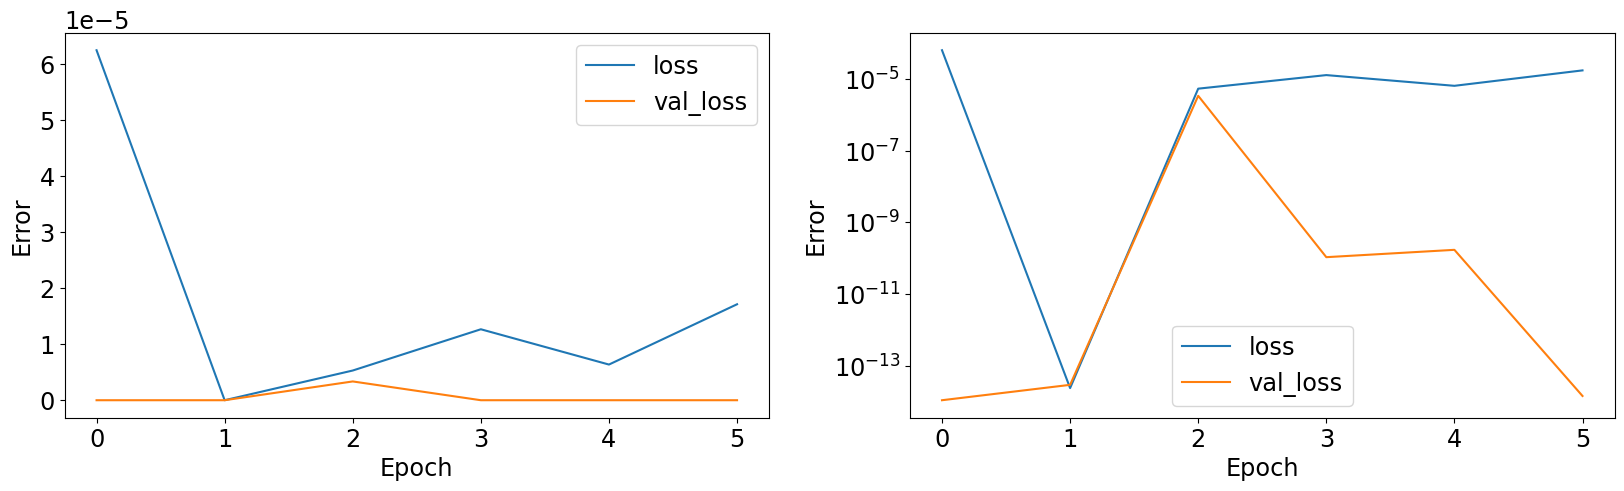

In [43]:
nEpochs = 15

initial_learning_rate = 5E-2
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate,
                decay_steps=nStepsPerEpoch*3,
                decay_rate=0.95,
                staircase=True)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
            #loss=tf.keras.losses.MeanAbsolutePercentageError(),
            loss="mse",
            metrics=[])

early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1, min_delta=1E-5)
callbacks = [early_stop_callback]

model.summary()
history = model.fit(dataset_train.skip(batchSize*4), epochs=nEpochs, validation_data=dataset_train.take(batchSize*4), callbacks=callbacks, verbose=1)
model.evaluate(dataset_train.take(16))
plf.plotTrainHistory(history)

print(colored("Model weights:","blue"))
print(colored("output:","blue"), model.get_layer('output').weights[0].numpy()[:,0])


pass

5) oszacowanie wydajności modelu na danych testowych

In [51]:
dataset_test = dataset.batch(128).map(func).take(32)
y_pred = model.predict(dataset_test)
y = np.array([y.numpy() for x,y in dataset_test.unbatch()])

pull = (y_pred - y)/y
pull = pull.flatten()
threshold = 1E-2

print(colored("Fraction of examples with abs(pull)<0.01:","blue"),"{:3.4f}".format(np.mean(np.abs(pull)<threshold)))
print(colored("Pull standard deviation:","blue"),"{:3.2f}".format(pull.std()))

pass

32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 155ms/step


2025-05-14 13:18:49.552834: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Fraction of examples with abs(pull)<0.01: 0.0117
Pull standard deviation: 7.91


2025-05-14 13:18:54.455451: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


W systuacji gdy zawartość obiektu `tf.Dastaset` pochodzi z generatora, jest ona generowana **za każdym**
pobraniem elementu zbioru.

**Proszę:**

* rozwiązać problem z różnicą wyników na zbiorach treningowym i testowym
* narysować histogram różnicy względnej:

$$
{\huge
\mathrm{pull} = \frac{\mathrm{model} - \mathrm{true}}{\mathrm{true}}
}
$$

32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 157ms/step
      2/Unknown 0s 2ms/step - loss: 1.3357e-14

2025-05-14 13:28:45.167130: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-05-14 13:28:45.332712: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.3980e-14
Fraction of examples with abs(pull)<0.01: 1.00
Pull standard deviation: 0.00


2025-05-14 13:28:45.396614: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-05-14 13:28:45.396628: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[Shape/_4]]


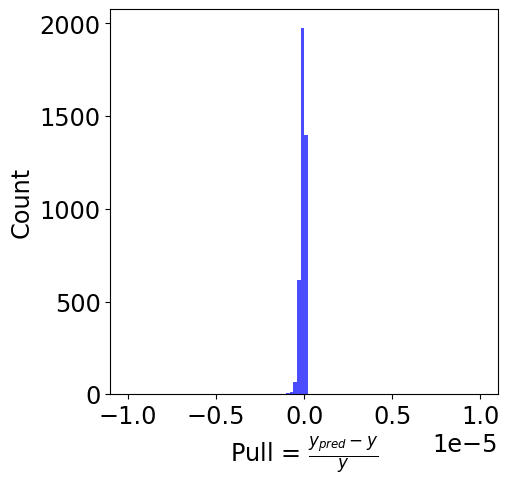

In [56]:
dataset_test = dataset.batch(128).map(func).take(32).cache()
y_pred = model.predict(dataset_test)
y = np.array([y.numpy() for x,y in dataset_test.unbatch()])

pull = (y_pred - y)/y
pull = pull.flatten()
threshold = 1E-2

fig, axis = plt.subplots(1, figsize=(5, 5))
axis.hist(pull, bins=100, range=(-1E-5, 1E-5), color='blue', alpha=0.7)
axis.set_xlabel(r"Pull = $\frac{y_{pred} - y}{y}$")
axis.set_ylabel("Count")
model.evaluate(dataset_test)

print(colored("Fraction of examples with abs(pull)<0.01:","blue"),"{:3.2f}".format(np.mean(np.abs(pull)<threshold)))
print(colored("Pull standard deviation:","blue"),"{:3.2f}".format(pull.std()))
pass

## Zbiory danych w TensorFlow datasets

Środowisko TensorFlow dostarcza wygodnego iterfejsu użytkownika do dostępu do publicznych zbiorów danych (podobnie jak inne pakiety):
[TensorFlow Datasets](https://www.tensorflow.org/datasets).


In [60]:
import tensorflow_datasets as tfds

#Create a dataset builder object
mnist_builder = tfds.builder('mnist')

#Download the dataset as a dictionary of tf.data.Datasets
data_dir = "../data/tensorflow_datasets/"

datasets, ds_info = tfds.load("mnist",
                              data_dir = data_dir,
                              with_info=True)

#Download the dataset as a tuple of tf.data.Datasets
#datasets, ds_info = tfds.load("mnist", as_supervised=True, with_info=True)

# Load data from disk as tf.data.Datasets
train_dataset, test_dataset = datasets['train'], datasets['test']

# Fetch the first batch of the dataset
item = next(iter(train_dataset.batch(16)))

print(colored("Features shape:", "blue"), item['image'].shape)
print(colored("Labels shape:", "blue"), item['label'].shape)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling ../data/tensorflow_datasets/mnist/incomplete.84BROA_3.0.1/mnist-train.tfrecord*...:   0%|          |…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling ../data/tensorflow_datasets/mnist/incomplete.84BROA_3.0.1/mnist-test.tfrecord*...:   0%|          | …

Dataset mnist downloaded and prepared to ../data/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.
Features shape: (16, 28, 28, 1)
Labels shape: (16,)


2025-05-14 13:33:33.994837: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Biblioteka `tensorflow_datasets` dostarcza użytecznej funkcji do testu  wydajności wczytytywania zbioru danych:

```Python
tfds.benchmark(train_dataset, # Obiekt który dostarcza interfejsu iteratora
                batch_size)   # Liczba służąca do normalizacji liczby wczytanych przykładów.
                              # Podział na paczki trzeba ustawić na zbiorze explicite.
```

**Proszę:**

* uruchomić dwukrotnie test wydajności na zbiorze MNIST wczytanym z użyciem modułu `tensorflow_datasets` dla paczki o rozmiarze `32`

In [61]:
batchSize = 32
train_dataset_batched = train_dataset.batch(batchSize)

tfds.benchmark(train_dataset_batched, batch_size=batchSize)
tfds.benchmark(train_dataset_batched, batch_size=batchSize)
pass


************ Summary ************



  0%|          | 0/1875 [00:00<?, ?it/s]

Examples/sec (First included) 85578.00 ex/sec (total: 60032 ex, 0.70 sec)
Examples/sec (First only) 1093.20 ex/sec (total: 32 ex, 0.03 sec)
Examples/sec (First excluded) 89256.92 ex/sec (total: 60000 ex, 0.67 sec)

************ Summary ************



2025-05-14 13:36:35.575570: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


  0%|          | 0/1875 [00:00<?, ?it/s]

Examples/sec (First included) 584615.05 ex/sec (total: 60032 ex, 0.10 sec)
Examples/sec (First only) 2286.64 ex/sec (total: 32 ex, 0.01 sec)
Examples/sec (First excluded) 676498.12 ex/sec (total: 60000 ex, 0.09 sec)


2025-05-14 13:36:35.686821: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Funkcja `tfds.show_examples(...)` pozwala na szybkie wyświetlenie przykładów z podanego zbioru.

**Uwaga:** funkcja wymaga obiektu `dataset_info.DatasetInfo`

2025-05-14 13:38:58.772386: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


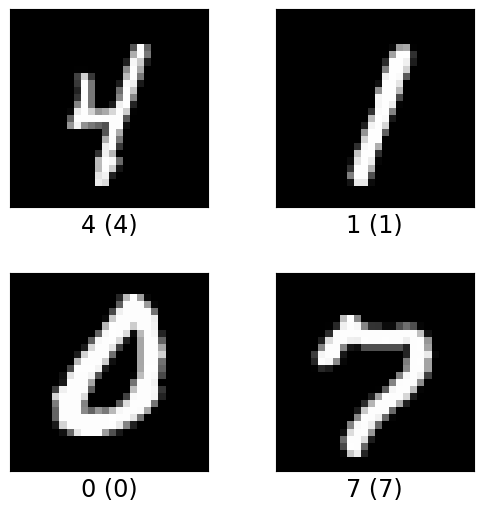

In [62]:
fig = tfds.show_examples(train_dataset, ds_info, rows=2, cols=2)

# Zadanie domowe

**Proszę:**

* napisać funkcję `load_wksf_dataset(filePath)` wczytującą i wstępnie przetwarzającą  zbiór fragmentów tekstow w języku polskim: [link](https://drive.google.com/drive/folders/18vDJPEZd2C6_-TualBIhsR5zmbhDA00D?usp=drive_link), pochodzący ze [Wzbogaconego korpusu słownika frekwencyjnego polszczyzny współczesnej](https://clarin-pl.eu/dspace/handle/11321/715)
* funkcja powinna wykonywać następujące kroki:
  * wczytywanie wszystkich plików w katalogu podanym jako `filePath` do obiektu `tf.data.Dataset`
  * przetwarzanie powstałego obiektu `tf.data.Dataset` by usunąć:
    * informację o źródle cytatu
    * odnośniki w tekście
    * sekwencje: `[/]`

* funkcję należy umieścić w pliku `text_functions.py`
 * uruchomić komórkę poniżej

**Wskazówka:**
* można użyć funkcji `tf.strings.regex_full_match(...)` oraz `tf.strings.regex_replace(...)` do filtrowania linii lub zastępowania
  fragmentów napisów
  

In [ ]:
import sys

import text_functions as txtfunc
importlib.reload(txtfunc)

filePath = "../data/wksf/Korpus_surowy/"
dataset = txtfunc.load_wksf_dataset(filePath)

for item in dataset.take(5):
    print(colored("Item:","blue"), end=" ")
    print(item.numpy().decode("utf-8"))